In [1]:
import numpy as np
import scipy.integrate
import scipy.interpolate
%matplotlib inline
import matplotlib as mpl, matplotlib.pyplot as plt, matplotlib.lines as mlines
import glob
import operator as op

from __future__ import print_function, division

mpl.rc('font', size=18)
mpl.rc('figure', figsize=(12,8))
mpl.rc('figure', autolayout=False)
mpl.rc('text', usetex=False)

In [2]:
# convert a string representation of a number
# of the sort produced by spherical_cloudy
# back into a numerical value, by replacing:
#     'd' with '.'
#     'p' with '+'
#     'n' with '-'
def deformat_string(s):
    return s.replace('d', '.').replace('p', '+').replace('m', '-')

ions = ['H I', 'D I', 'He I', 'He II']
nions = len(ions)

sph_cloudy_dtype = ([('rad', 'float64'),           # radius
                     ('temp', 'float64'),          # temperature
                     #('masspp', 'float64'),        # mean particle mass
                     ('hden', 'float64'),          # HI volume density
                     ('HaSB', 'float64'),          # surface brightness in H-alpha
                     ('vden', 'float64', nions),   # volume density for each species
                     ('cden', 'float64', nions)])  # column density for each species

class SphCloudyResult:
    def __init__(self, fname):
        self.fname = fname
        self.data = np.load(fname).flatten()
        self.data.dtype = sph_cloudy_dtype
        
        # parse the file name to extract model parameters
        self.params = dict()
        end_of_rel_path = fname.rfind('/') + 1
        fname_parts = fname[end_of_rel_path:].split('_')
        for part in fname_parts:
            if(part == 'NFW'):
                self.params['profile'] = 'NFW'
            elif part.startswith('mass'):
                mass_str = deformat_string(part[4:])
                self.params['mass'] = float(mass_str)
            elif part.startswith('redshift'):
                z_str = deformat_string(part[8:])
                self.params['redshift'] = float(z_str)
            elif part.startswith('baryscl'):
                bary_str = deformat_string(part[7:])
                self.params['bary_scl'] = float(bary_str)
            elif part.startswith('HMscale'):
                He_str = deformat_string(part[7:])
                self.params['HM_scl'] = float(He_str)
            else:
                # remaining part is nrad_nmu (.npy)
                nrad, nmu = (part.rstrip('.npy').split('-'))
                self.params['n_rad'] = nrad
                self.params['nmu'] = nmu

## Load data from spherical_cloudy

In [26]:
sph_cloudy_files = glob.glob('../output/hubb_eqbm_auto/NFW*.npy')
sph_cloudy_data = [SphCloudyResult(f) for f in sph_cloudy_files]

def compose(f, g):
    return lambda x: f(g(x))

nvalues = 1000
nhaloes = len(sph_cloudy_data)

sorted_by_mass = sorted(sph_cloudy_data, key=compose(op.itemgetter('mass'),op.attrgetter('params')))
sph_cloudy_masses = 10**np.array(list(map(compose(op.itemgetter('mass'),op.attrgetter('params')), sorted_by_mass)))
sph_cloudy_radii = np.array([res.data['rad'] for res in sorted_by_mass]).reshape(nhaloes, nvalues)
sph_cloudy_lognh = np.log10([res.data['hden'] for res in sorted_by_mass]).reshape(nhaloes, nvalues)
sph_cloudy_logT = np.log10([res.data['temp'] for res in sorted_by_mass]).reshape(nhaloes, nvalues)
#sph_cloudy_mu = np.array([res.data['masspp'] for res in sorted_by_mass]).reshape(nhaloes, nvalues)

## Load data from my model

In [27]:
cm_per_kpc = 3e10 * 86400 * 365 * 3.26 * 1000
mp = 1.673e-24

fname_base = '../output/rhos_gas_eagle_relhic'

# Masses and radii are the same for Eagle/Prada models
my_masses = np.loadtxt(fname_base + '_masses.dat', ndmin=1)

nhaloes = len(my_masses)
nvalues = 1000

R200s = np.loadtxt(fname_base + '_Rvirs.dat').flatten()
my_radii, _ = np.hsplit(np.loadtxt(fname_base + '.dat'), [1])
my_radii = (my_radii[:,np.newaxis] * R200s / cm_per_kpc).transpose().reshape(nhaloes, nvalues)

# Eagle
_, my_lognh_eagle, my_temps_eagle = np.hsplit(np.loadtxt(fname_base + '.dat'), [1, 1 + nhaloes])
my_lognh_eagle = np.log10(my_lognh_eagle / mp).transpose()
my_temps_eagle =my_temps_eagle.transpose()

fname_base = '../output/rhos_gas_prada_relhic'

# Prada
_, my_lognh_prada, my_temps_prada = np.hsplit(np.loadtxt(fname_base + '.dat'), [1, 1 + nhaloes])
my_lognh_prada = np.log10(my_lognh_prada / mp).transpose()
my_temps_prada = my_temps_prada.transpose()

## Gas density profile

/home/hrzc75/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


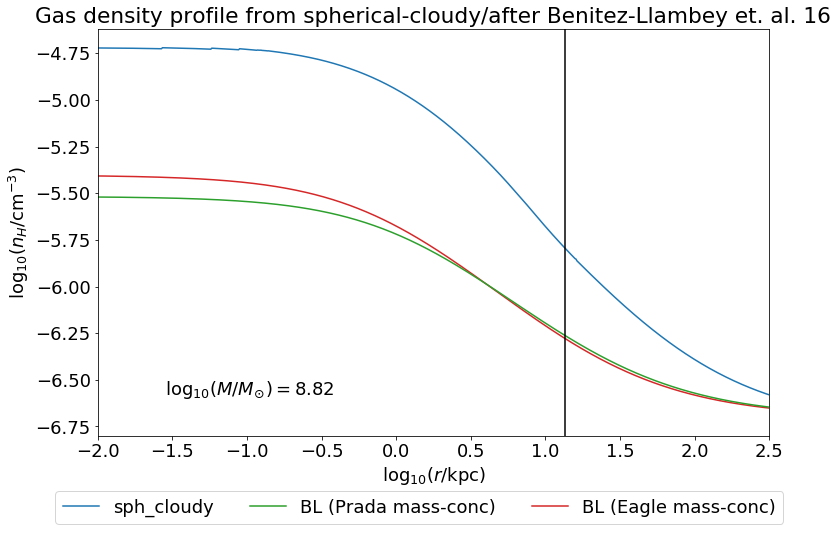

In [34]:
i = 5

fig = plt.figure()
ax = plt.gca()
ax.set_title('Gas density profile from spherical-cloudy/after Benitez-Llambey et. al. 16')
ax.set_xlim(-2, 2.5)
ax.set_xlabel(r'$\log_{10}(r/\mathrm{kpc})$')
ax.set_ylabel(r'$\log_{10}(n_H/\mathrm{cm}^{-3})$')
ax.plot(np.log10(sph_cloudy_radii[i] / 1000), sph_cloudy_lognh[i], c='tab:blue')
ax.plot(np.log10(my_radii[i]), my_lognh_eagle[i], c='tab:red')
ax.plot(np.log10(my_radii[i]), my_lognh_prada[i], c='tab:green')
ax.axvline(np.log10(R200s[i]/cm_per_kpc), c='k')
ax.annotate(s=r'$\log_{{10}}(M/M_{{\!\odot\!}})={:.2f}$'.format(np.log10(sph_cloudy_masses[i])), xy=(0.1, 0.1), xycoords='axes fraction') 
lines = [mlines.Line2D([], [], c='tab:blue'), mlines.Line2D([], [], c='tab:green'), mlines.Line2D([], [], c='tab:red')]
labels = ['sph_cloudy', 'BL (Prada mass-conc)', 'BL (Eagle mass-conc)']
fig.legend(lines, labels, ncol=3, loc='lower center')
fig.tight_layout(rect=[0,0.05,1,0.95])
#fig.savefig('dp_compare.pdf', bbox_inches='tight')

## Gas pressure profile

/home/hrzc75/.local/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


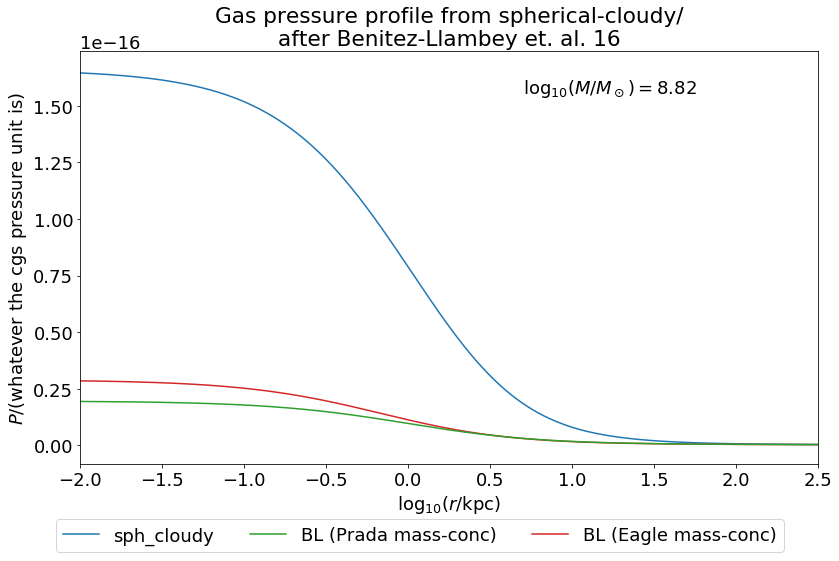

In [35]:
kB = 1.3807e-16
mu = 3/7
mp = 1.673e-24

def my_P(lognh, T):
    return 10**lognh * kB * T / mu

fig = plt.figure()
ax = plt.gca()
ax.set_title('Gas pressure profile from spherical-cloudy/\nafter Benitez-Llambey et. al. 16')
ax.set_xlim(-2, 2.5)
ax.set_xlabel(r'$\log_{10}(r/\mathrm{kpc})$')
ax.set_ylabel(r'$P/(\mathrm{whatever\ the\ cgs\ pressure\ unit\ is})$')
ax.plot(np.log10(sph_cloudy_radii[i] / 1000), my_P(sph_cloudy_lognh[i], 10**sph_cloudy_logT[i]), c='tab:blue')
ax.plot(np.log10(my_radii[i]), my_P(my_lognh_eagle[i], my_temps_eagle[i]), c='tab:red')
ax.plot(np.log10(my_radii[i]), my_P(my_lognh_prada[i], my_temps_prada[i]), c='tab:green')
ax.annotate(s=r'$\log_{{10}}(M/M_\odot)={:.2f}$'.format(np.log10(sph_cloudy_masses[i])), xy=(0.6, 0.9), xycoords='axes fraction') 
fig.legend(lines, labels, ncol=3, loc='lower center')
fig.tight_layout(rect=[0,0.05,1,1])

## $n_H-T$ relation

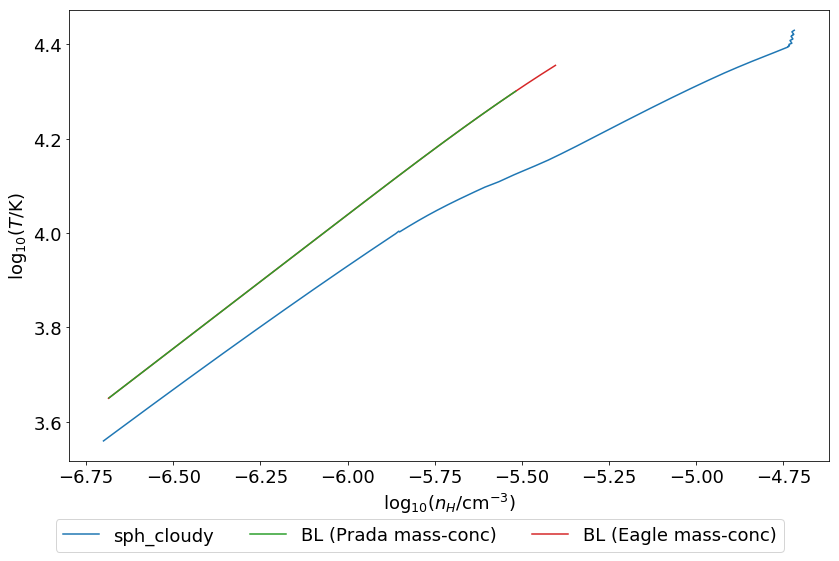

In [36]:
fig = plt.figure()
ax = plt.gca()
ax.set_xlabel(r'$\log_{10}(n_H/\mathrm{cm}^{-3})$')
ax.set_ylabel(r'$\log_{10}(T/\mathrm{K})$')
ax.plot(sph_cloudy_lognh[i], sph_cloudy_logT[i], c='tab:blue')
ax.plot(my_lognh_eagle[i], np.log10(my_temps_eagle[i]), c='tab:red')
ax.plot(my_lognh_prada[i], np.log10(my_temps_prada[i]), c='tab:green')
fig.legend(lines, labels, ncol=3, loc='lower center')
fig.tight_layout(rect=[0,0.05,1,1])

## Temperature profiles

/home/hrzc75/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


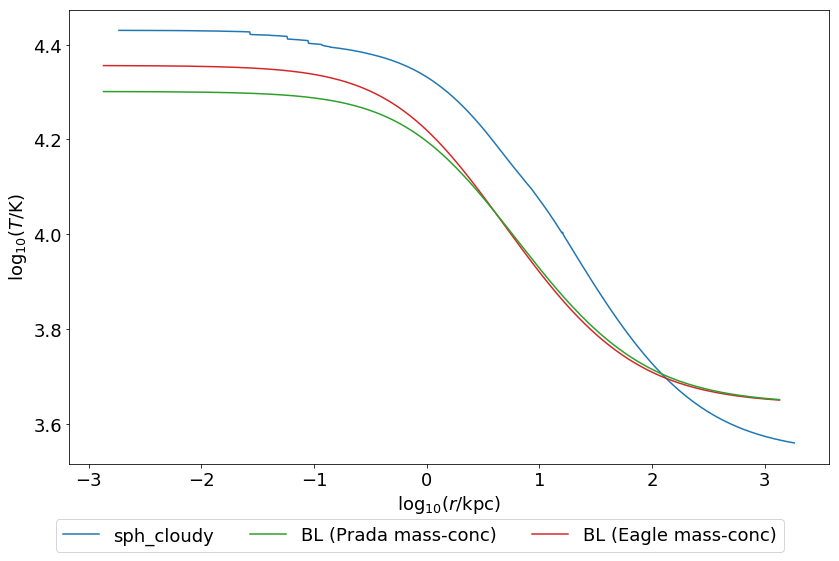

In [37]:
fig = plt.figure()
ax = plt.gca()
ax.set_xlabel(r'$\log_{10}(r/\mathrm{kpc})$')
ax.set_ylabel(r'$\log_{10}(T/\mathrm{K})$')
ax.plot(np.log10(sph_cloudy_radii[i] / 1000), sph_cloudy_logT[i], c='tab:blue')
ax.plot(np.log10(my_radii[i]), np.log10(my_temps_eagle[i]), c='tab:red')
ax.plot(np.log10(my_radii[i]), np.log10(my_temps_prada[i]), c='tab:green')
fig.legend(lines, labels, ncol=3, loc='lower center')
fig.tight_layout(rect=[0,0.05,1,1])

## Comparison of $M_\mathrm{gas}$

In [26]:
pc_in_cm = 3.0842208e+18
kpc_in_cm = 1000 * pc_in_cm
solmass = 1.990e33
rho200 = 200 * 8.46543558829e-30

def M_gas(rads, rhos):
    if len(rads):
        return 4 * np.pi * scipy.integrate.simps(rads**2 * rhos, rads) / solmass
    else:
        return 0

my_gas_masses_eagle = [M_gas(rads[rads/rv <=1], rhos[rads/rv <=1]) for rads, rhos, rv in zip(my_radii * kpc_in_cm, 10**my_lognh_eagle*mp, R200s)]
my_gas_masses_prada = [M_gas(rads[rads/rv <=1], rhos[rads/rv <=1]) for rads, rhos, rv in zip(my_radii * kpc_in_cm, 10**my_lognh_prada*mp, R200s)]

r200 = lambda m200: (3 * m200 * solmass / (4 * np.pi * rho200))**(1/3)
sph_cloudy_gas_masses = [M_gas(rads[rads <= rv], rhos[rads <= rv]) for rads, rhos, rv in zip(sph_cloudy_radii * pc_in_cm, 10**sph_cloudy_lognh*mp, r200(sph_cloudy_masses))]

print('Spherical_cloudy',sph_cloudy_gas_masses[i],'Eagle M-c', my_gas_masses_eagle[i], 'Prada M-c', my_gas_masses_prada[i])

Spherical_cloudy 49112.9451432 Eagle M-c 39835.237076 Prada M-c 40562.6421497


/home/hrzc75/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


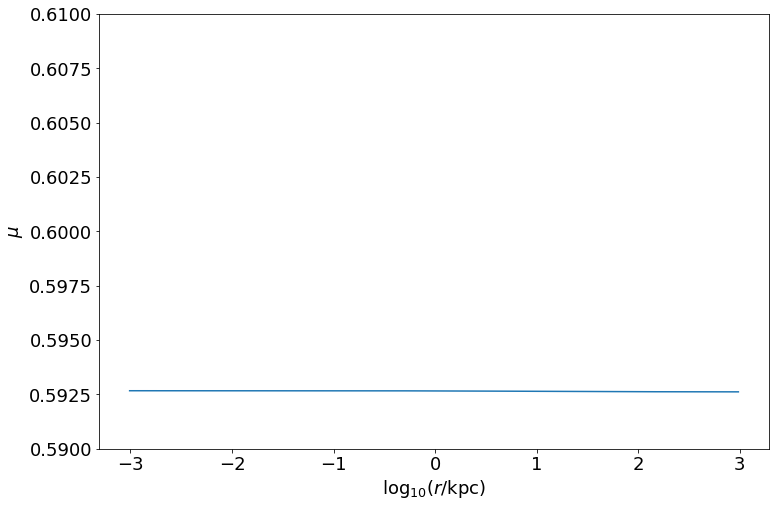

In [27]:
plt.figure()
ax = plt.gca()
ax.set_ylabel(r'$\mu$')
ax.set_xlabel(r'$\log_{10}(r/\mathrm{kpc})$')
ax.set_ylim(0.59,0.61)
plt.plot(np.log10(sph_cloudy_radii[i]/1000), sph_cloudy_mu[i])

In [28]:
rv = R200s[my_masses == 10**9.0725] / cm_per_kpc * 1000
rs = rv / 10.922312892867197

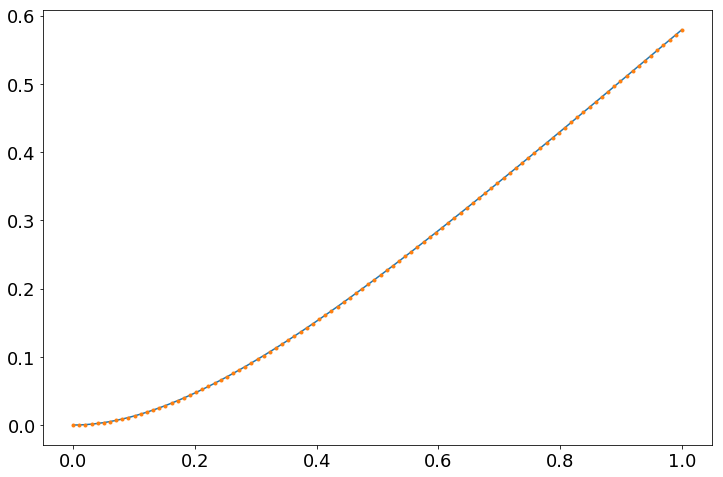

In [29]:
def NFW_fm(x):
    return 3.0*(np.log(1.0+x) - x/(1.0+x))

def my_fm(r, rs):
    return 3*(np.log((rs + r) / rs) - r / (rs + r))
                                 
# since x = r/rs

xvals = np.linspace(0, 1, 100)
rvals = np.linspace(0, 10, 100)
rs = 10

plt.figure()
plt.plot(xvals, NFW_fm(xvals))
plt.plot(rvals/rs, my_fm(rvals, rs), '.')